# Experiment 2: LocalMax Acquisition Functions
This notebook shows detailed plots of the experiments on changing the underlying sequential acquisition function within local max. The experiment tests the impact of varrying acquisition functions on each dataset. 

Acquisition functions:
- uncertainty
- vopt
- model change
- mcvopt

Embeddings:
- CNNVAE
- Zero-shot Transfer Learning
- Fine Tuned Transfer Learning

Datasets:
- MSTAR
- OpenSARShip
- FUSAR-Ship

## TODO: Change the experiments to do fine tuning also

In [1]:
import numpy as np
import pandas as pd
import torch as th
import matplotlib.pyplot as plt

import graphlearning as gl


import batch_active_learning as bal
import utils

# TODO: Need to get the parameters correct for bal.run_coreset_experiment

## Parameters and Function Definitions

In [2]:
#Non-default Parameters

save_path = "Experiment Results/Experiment 2/"

In [3]:
def experiment2_simple_plotter(x_vals, y_dict, dataset):
    _, ax1 = plt.subplots()

    ax1.set_xlabel("Number of Labeled Points")
    ax1.set_ylabel("Accuracy (%)")
    for this_key in bal.ACQUISITION_FUNCTIONS:
        ax1.plot(x_vals, y_dict[this_key], label=this_key)
    ax1.tick_params(axis="x")

    # Add SoTA
    if dataset != "mstar":
        if dataset == "open_sar_ship":
            sota_val = 78.15
        elif dataset == "fusar":
            sota_val = 86.69
        ax1.plot(x_vals, sota_val * np.ones_like(x_vals), label="SoTA", linestyle="--")

    ax1.legend()
    plt.show()
    return


def experiment2(dataset, embedding):
    assert dataset in utils.AVAILABLE_SAR_DATASETS, "Invalid dataset"
    assert embedding in utils.AVAILABLE_EMBEDDINGS, "Invalid embedding"

    if embedding == "fine_tuned_tl":
        max_new_samples = bal.FINE_TUNED_MAX_NEW_SAMPLES_DICT[dataset]
    else:
        max_new_samples = bal.MAX_NEW_SAMPLES_DICT[dataset]

    # Perform embedding
    if embedding == "cnnvae":
        X, labels, knn_data = utils.CNNVAE(dataset)
    elif embedding == "zero_shot_tl":
        X, labels, knn_data = utils.zero_shot_TL(dataset)
    else:
        X, labels, knn_data = utils.fine_tuned_TL(dataset)

    if isinstance(X, th.Tensor):
        X = X.numpy()
    if isinstance(labels, th.Tensor):
        labels = labels.numpy()

    # Create graph objects
    W = gl.weightmatrix.knn(X, utils.KNN_NUM, kernel="gaussian", knn_data=knn_data)
    G = gl.graph(W)

    num_iter = max_new_samples // bal.BATCH_SIZE

    acc_dict = {}

    # Ensure each label is represented in core set
    initial = gl.trainsets.generate(labels, rate=1).tolist()

    coreset = bal.coreset_dijkstras(
        G,
        rad=bal.DENSITY_RADIUS,
        data=X,
        initial=initial,
        density_info=(True, bal.DENSITY_RADIUS, 1),
        knn_data=knn_data,
    )

    for acq_fun in bal.ACQUISITION_FUNCTIONS:

        _, num_labels, acc_vals, _ = bal.coreset_run_experiment(
            X,
            labels,
            W,
            coreset,
            num_iter=num_iter,
            method="Laplace",
            display=False,
            use_prior=False,
            al_mtd="local_max",
            acq_fun=acq_fun,
            knn_data=knn_data,
            mtd_para=None,
            savefig=False,
            batchsize=bal.BATCH_SIZE,
            dist_metric="angular",
            knn_size=utils.KNN_NUM,
            q=1,
            thresholding=0,
        )

        acc_dict[acq_fun] = acc_vals

    num_labels_array = np.array(num_labels)

    ##Plot and save
    experiment2_simple_plotter(num_labels_array, acc_dict, dataset)

    ##Save numpy arrays and pickles
    new_save_path = save_path + "Pickles/" + dataset + "_" + embedding

    np.save(new_save_path + "_num_labels_array.npy", num_labels_array)

    df_acc = pd.DataFrame.from_dict(acc_dict, orient="index")
    df_acc.to_pickle(new_save_path + "_acc_dict.pkl")

    return num_labels_array, acc_dict


## Running Experiments

mstar cnnvae
Using pre-computed cnnvae embedding knn_data


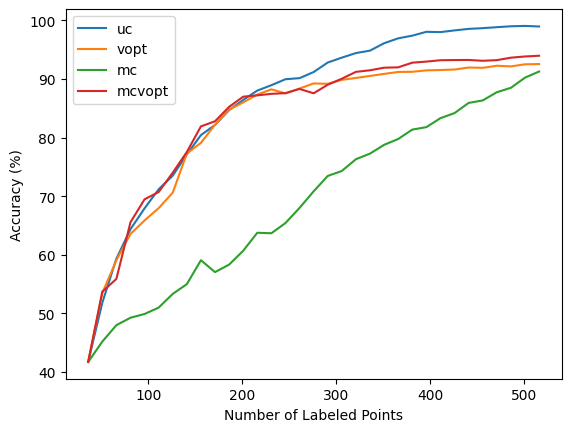

mstar zero_shot_tl


Using cache found in /Users/jameschapman/.cache/torch/hub/pytorch_vision_v0.10.0
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


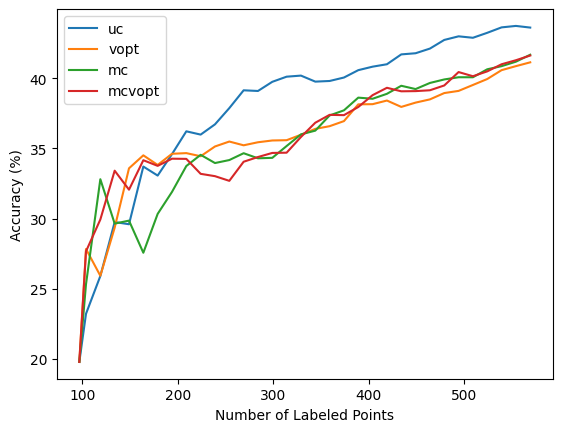

mstar fine_tuned_tl


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train Loss: 2.4836 Acc: 0.1076
val Loss: 2.3371 Acc: 0.1383

Epoch 2/10
----------
train Loss: 2.2830 Acc: 0.2122
val Loss: 2.3041 Acc: 0.1841

Epoch 3/10
----------
train Loss: 2.2976 Acc: 0.1831
val Loss: 2.2994 Acc: 0.1799

Epoch 4/10
----------
train Loss: 2.2613 Acc: 0.1919
val Loss: 2.3337 Acc: 0.1602

Epoch 5/10
----------
train Loss: 2.2586 Acc: 0.1890
val Loss: 2.3320 Acc: 0.1753

Epoch 6/10
----------
train Loss: 2.2354 Acc: 0.2122
val Loss: 2.2795 Acc: 0.1812

Epoch 7/10
----------
train Loss: 2.2035 Acc: 0.2064
val Loss: 2.2537 Acc: 0.1998

Epoch 8/10
----------
train Loss: 2.2073 Acc: 0.2209
val Loss: 2.2412 Acc: 0.1922

Epoch 9/10
----------
train Loss: 2.2094 Acc: 0.2035
val Loss: 2.2417 Acc: 0.1946

Epoch 10/10
----------
train Loss: 2.2040 Acc: 0.2355
val Loss: 2.2385 Acc: 0.1954

Training complete in 49m 33s
Best val Acc: 0.199847


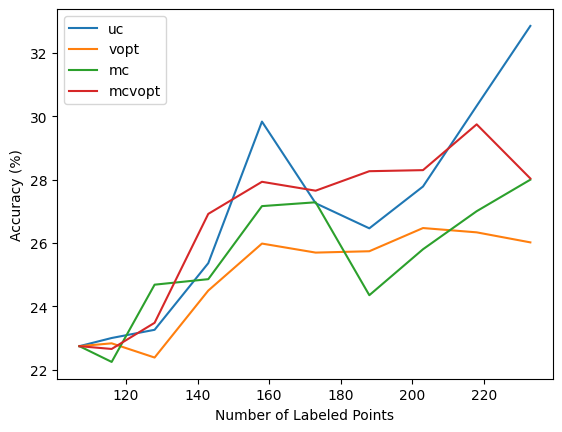

open_sar_ship cnnvae
Using pre-computed cnnvae embedding knn_data


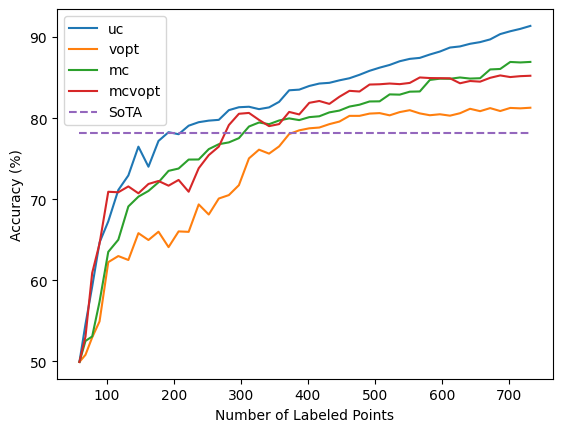

open_sar_ship zero_shot_tl


Using cache found in /Users/jameschapman/.cache/torch/hub/pytorch_vision_v0.10.0
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


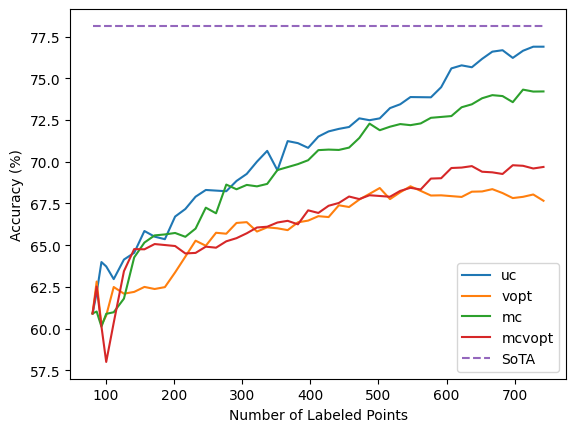

open_sar_ship fine_tuned_tl


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train Loss: 1.2062 Acc: 0.1519
val Loss: 1.0599 Acc: 0.2590

Epoch 2/10
----------
train Loss: 1.1044 Acc: 0.2722
val Loss: 1.0753 Acc: 0.5577

Epoch 3/10
----------
train Loss: 1.1041 Acc: 0.2179
val Loss: 1.0820 Acc: 0.6482

Epoch 4/10
----------
train Loss: 1.1037 Acc: 0.2564
val Loss: 1.0829 Acc: 0.6646

Epoch 5/10
----------
train Loss: 1.1026 Acc: 0.2722
val Loss: 1.0798 Acc: 0.6693

Epoch 6/10
----------
train Loss: 1.0994 Acc: 0.3136
val Loss: 1.0769 Acc: 0.6646

Epoch 7/10
----------
train Loss: 1.0946 Acc: 0.3235
val Loss: 1.0686 Acc: 0.6747

Epoch 8/10
----------
train Loss: 1.0811 Acc: 0.4606
val Loss: 1.0677 Acc: 0.6724

Epoch 9/10
----------
train Loss: 1.0770 Acc: 0.4477
val Loss: 1.0661 Acc: 0.6755

Epoch 10/10
----------
train Loss: 1.0767 Acc: 0.4576
val Loss: 1.0649 Acc: 0.6685

Training complete in 24m 38s
Best val Acc: 0.675507


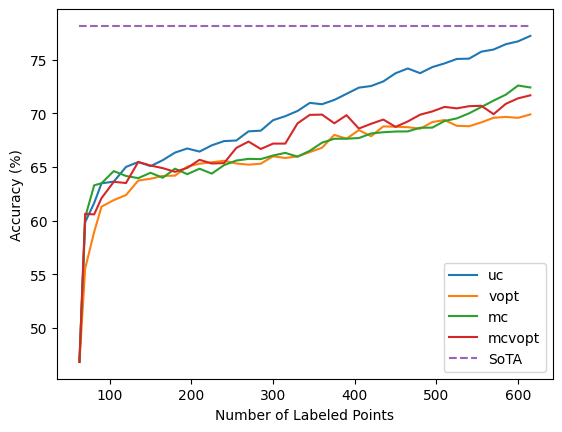

fusar cnnvae
Using pre-computed cnnvae embedding knn_data


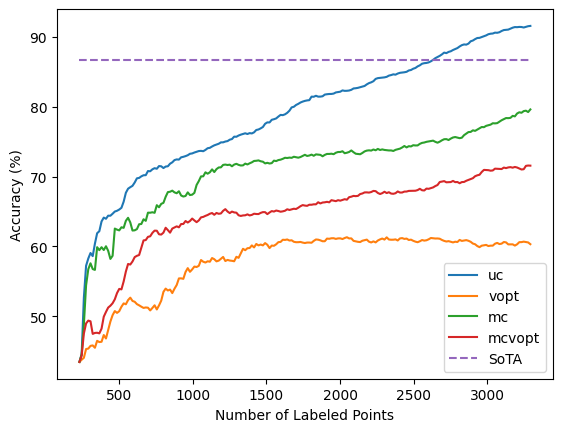

fusar zero_shot_tl


Using cache found in /Users/jameschapman/.cache/torch/hub/pytorch_vision_v0.10.0
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


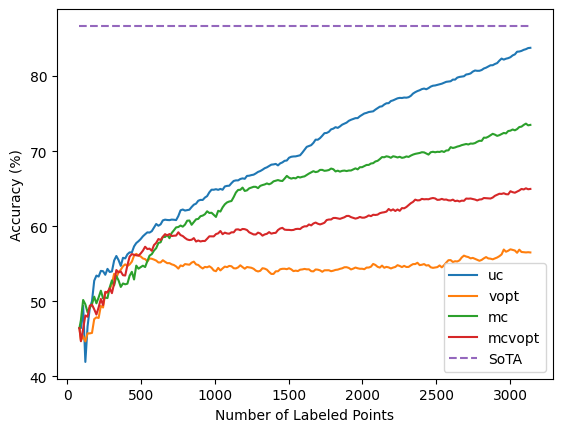

fusar fine_tuned_tl


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train Loss: 1.5634 Acc: 0.4198
val Loss: 1.5267 Acc: 0.4461

Epoch 2/10
----------
train Loss: 1.4911 Acc: 0.4301
val Loss: 1.4606 Acc: 0.4475

Epoch 3/10
----------
train Loss: 1.4344 Acc: 0.4301
val Loss: 1.4103 Acc: 0.4475

Epoch 4/10
----------
train Loss: 1.3915 Acc: 0.4301
val Loss: 1.3745 Acc: 0.4475

Epoch 5/10
----------
train Loss: 1.3588 Acc: 0.4301
val Loss: 1.3466 Acc: 0.4475

Epoch 6/10
----------
train Loss: 1.3346 Acc: 0.4301
val Loss: 1.3251 Acc: 0.4475

Epoch 7/10
----------
train Loss: 1.3150 Acc: 0.4301
val Loss: 1.3069 Acc: 0.4475

Epoch 8/10
----------
train Loss: 1.3050 Acc: 0.4301
val Loss: 1.3068 Acc: 0.4475

Epoch 9/10
----------
train Loss: 1.3043 Acc: 0.4301
val Loss: 1.3046 Acc: 0.4475

Epoch 10/10
----------
train Loss: 1.3030 Acc: 0.4301
val Loss: 1.3037 Acc: 0.4475

Training complete in 94m 47s
Best val Acc: 0.447495


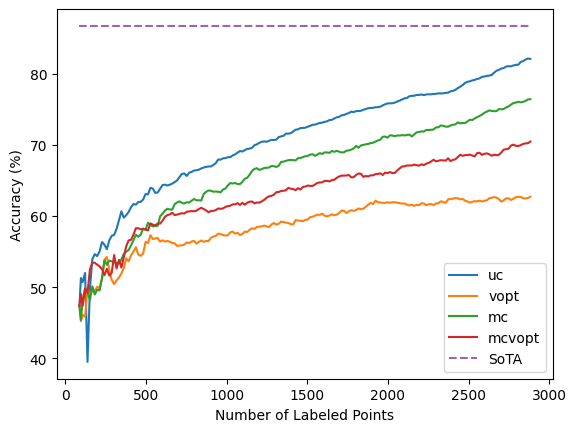

In [4]:
for dataset in utils.AVAILABLE_SAR_DATASETS:
    for embedding in utils.AVAILABLE_EMBEDDINGS:
        print(dataset + " " + embedding)
        experiment2(dataset, embedding)